In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdmolops
from rdkit.Chem.MolStandardize import rdMolStandardize
import pandas as pd

In [3]:
bez_AF=pd.read_csv("bez_AF.csv")
bez_AF

,PREFERRED_NAME,CASRN,SMILES,Assay List TOX21_AhR_LUC_Agonist-2025-05-31_HIT CALL,Assay List TOX21_AP1_BLA_Agonist_ratio-2025-03-17_HIT CALL,Assay List TOX21_ARE_BLA_Agonist_ratio-2025-03-17_HIT CALL,Assay List TOX21_Aromatase_Inhibition-2025-05-31_HIT CALL,Assay List TOX21_AR_BLA_Agonist_ratio-2025-05-31_HIT CALL,Assay List TOX21_AR_BLA_Antagonist_ratio-2025-03-17_HIT CALL,Assay List TOX21_AR_LUC_MDAKB2_Agonist-2025-05-31_HIT CALL,...,TOX21_SBE_BLA_Antagonist_viability_HIT CALL_y,TOX21_SHH_3T3_GLI3_Agonist_viability_HIT CALL_y,TOX21_SHH_3T3_GLI3_Antagonist_viability_HIT CALL_y,TOX21_TRB_BLA_Agonist_Followup_viability_HIT CALL_y,TOX21_TRB_BLA_Antagonist_Followup_viability_HIT CALL_y,TOX21_TR_LUC_GH3_Antagonist_viability_HIT CALL_y,TOX21_TR_RXR_BLA_Agonist_Followup_viability_HIT CALL_y,TOX21_TR_RXR_BLA_Antagonist_Followup_viability_HIT CALL_y,TOX21_VDR_BLA_Agonist_viability_HIT CALL_y,TOX21_VDR_BLA_Antagonist_viability_HIT CALL_y
0,"((3,4-Dihydroxyphenyl)methylene)-Propanedinitrile",118409-57-7,OC1=C(O)C=C(C=C(C#N)C#N)C=C1,Inactive,Inactive,Active,NaN,Inactive,Inactive,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
1,(+)-2-Methylbutyl-4-methoxybenzyladine-4'-amin...,24140-30-5,CC[C@H](C)COC(=O)\C=C\C1=CC=C(C=C1)\N=C\C1=CC=...,Inactive,Active,Inactive,Active,Inactive,Active,Inactive,...,Inactive,Inactive,Active,NaN,NaN,Inactive,NaN,NaN,Active,Active
2,(+)-Cedrol,77-53-2,[H][C@@]12CC[C@@H](C)[C@]11C[C@]([H])(C2(C)C)[...,Inactive,Active,Active,NaN,Inactive,Inactive,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
3,(+)-Cyclazocine,7313-87-3,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,Inactive,NaN,NaN,NaN,Inactive,Inactive,Inactive,...,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,NaN,NaN,NaN
4,(+)-Diltiazem,42399-41-7,COC1=CC=C(C=C1)[C@@H]1SC2=CC=CC=C2N(CCN(C)C)C(...,Inactive,Inactive,Inactive,NaN,Inactive,Inactive,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6854,trans-beta-Farnesene,18794-84-8,CC(C)=CCC\C(C)=C\CCC(=C)C=C,NaN,Inactive,NaN,NaN,NaN,NaN,NaN,...,Inactive,Inactive,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6855,{2-[2-(Ethenyloxy)ethoxy]ethoxy}ethene,764-99-8,C=COCCOCCOC=C,Inactive,Inactive,Inactive,NaN,Inactive,Inactive,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6856,{4-[(Ethenyloxy)methyl]cyclohexyl}methanol,114651-37-5,OCC1CCC(COC=C)CC1,Inactive,Inactive,Inactive,NaN,Inactive,Inactive,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6857,{4-[({2-[3-Fluoro-4-(trifluoromethyl)phenyl]-4...,317318-84-6,CC1=C(CSC2=CC(C)=C(OCC(O)=O)C=C2)SC(=N1)C1=CC=...,Inactive,Inactive,Inactive,NaN,Inactive,Active,Inactive,...,Inactive,Active,Active,NaN,NaN,Active,NaN,NaN,Active,Active


In [4]:
# Neželjeni atomi
metal_atoms = {
    3, 4, 11, 12, 13, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
    29, 30, 31, 32, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
    47, 48, 49, 50, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
    81, 82, 83, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
    99, 100, 101, 102, 103
}
heavy_atoms = {
    21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34,
    37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
    50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
    65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
    78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
    91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
    103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
    114, 115, 116, 117, 118
}
unwanted_atom_set = metal_atoms.union(heavy_atoms)

In [5]:
# Neutralizacija naboja
def _initialise_neutralisation_reactions():
    patterns = [
        ('[n+;H]', 'n'), ('[N+;!H0]', 'N'), ('[$([O-]);!$([O-][#7])]', 'O'),
        ('[S-;X1]', 'S'), ('[$([N-;X2]S(=O)=O)]', 'N'), ('[$([N-;X2][C,N]=C)]', 'N'),
        ('[n-]', '[nH]'), ('[$([S-]=O)]', 'S'), ('[$([N-]C=O)]', 'N'),
    ]
    return [(Chem.MolFromSmarts(p), Chem.MolFromSmiles(r, False)) for p, r in patterns]

def neutralize_charges(mol, reactions=None):
    if reactions is None:
        reactions = _initialise_neutralisation_reactions()
    for reactant, product in reactions:
        while mol.HasSubstructMatch(reactant):
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol

In [6]:
# Glavna funkcija za čišćenje SMILES zapisa
def clean_smiles_column(df, smiles_column="SMILES"):
    canonic_smiles = []
    isomeric_smiles = []

    for smi in df[smiles_column]:
        try:
            # 1. Konverzija SMILES u Mol objekt
            mol = Chem.MolFromSmiles(smi)
            if mol is None or mol.GetNumAtoms() == 0:
                canonic_smiles.append("")
                isomeric_smiles.append("")
                continue

            # 2. Uklanjanje anorganskih molekula
            atom_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
            if 6 not in atom_nums:
                canonic_smiles.append("")
                isomeric_smiles.append("")
                continue

            # 3. Zadržavanje najvećeg fragmenta
            lfc = rdMolStandardize.LargestFragmentChooser()
            mol = lfc.choose(mol)

            # 4. Uklanjanje neželjenih atoma
            atom_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
            if not set(atom_nums).isdisjoint(unwanted_atom_set):
                canonic_smiles.append("")
                isomeric_smiles.append("")
                continue

            # 5. Neutralizacija naboja
            mol = neutralize_charges(mol)

            # 6. Provjera valencije
            try:
                Chem.SanitizeMol(mol)
            except:
                canonic_smiles.append("")
                isomeric_smiles.append("")
                continue

            # 7. Tautomerizacija
            te = rdMolStandardize.TautomerEnumerator()
            mol = te.Canonicalize(mol)

            # 8. Kekulizacija
            try:
                Chem.Kekulize(mol, clearAromaticFlags=True)
            except:
                pass  # Neke strukture ne mogu biti kekulizirane (ostaju aromatske)

            # 9. Kanonski SMILES + izomerijski
            smi_std = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False)
            smi_iso = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True)

            # 10. Pohrana rezultata
            canonic_smiles.append(smi_std)
            isomeric_smiles.append(smi_iso)

        except Exception as e:
            canonic_smiles.append("")
            isomeric_smiles.append("")
            print(f"Greška za SMILES: {smi} - {e}")

    # Spremanje u novi DataFrame
    df["smiles_canonic"] = canonic_smiles
    df["smiles_isomeric"] = isomeric_smiles
    df = df[df["smiles_canonic"] != ""].reset_index(drop=True)
    return df

In [7]:
standardizirano = clean_smiles_column(bez_AF, smiles_column="SMILES")

[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragmentChooser
[13:30:46] Running LargestFragment

Greška za SMILES: nan - No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type float


[13:31:35] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragment

Greška za SMILES: nan - No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type float


[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragmentChooser
[13:31:36] Running LargestFragment

Greška za SMILES: nan - No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type float


[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:37] Running LargestFragmentChooser
[13:31:38] Running LargestFragmentChooser
[13:31:38] Running LargestFragmentChooser
[13:31:38] Running LargestFragmentChooser
[13:31:38] Running LargestFragment

Greška za SMILES: nan - No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type float


[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragmentChooser
[13:32:59] Running LargestFragment

Greška za SMILES: nan - No registered converter was able to produce a C++ rvalue of type class std::basic_string<wchar_t,struct std::char_traits<wchar_t>,class std::allocator<wchar_t> > from this Python object of type float


[13:33:04] Tautomer enumeration stopped at 719 tautomers: max transforms reached
[13:33:04] Running LargestFragmentChooser
[13:33:04] Running LargestFragmentChooser
[13:33:04] Running LargestFragmentChooser
[13:33:04] Running LargestFragmentChooser
[13:33:04] Running LargestFragmentChooser
[13:33:04] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Fragment: *C
[13:33:05] New largest fragment: *C (5)
[13:33:05] Fragment: Cc1ccccc1
[13:33:05] New largest fragment: Cc1ccccc1 (15)
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running LargestFragmentChooser
[13:33:05] Running L

In [8]:
standardizirano

,PREFERRED_NAME,CASRN,SMILES,Assay List TOX21_AhR_LUC_Agonist-2025-05-31_HIT CALL,Assay List TOX21_AP1_BLA_Agonist_ratio-2025-03-17_HIT CALL,Assay List TOX21_ARE_BLA_Agonist_ratio-2025-03-17_HIT CALL,Assay List TOX21_Aromatase_Inhibition-2025-05-31_HIT CALL,Assay List TOX21_AR_BLA_Agonist_ratio-2025-05-31_HIT CALL,Assay List TOX21_AR_BLA_Antagonist_ratio-2025-03-17_HIT CALL,Assay List TOX21_AR_LUC_MDAKB2_Agonist-2025-05-31_HIT CALL,...,TOX21_SHH_3T3_GLI3_Antagonist_viability_HIT CALL_y,TOX21_TRB_BLA_Agonist_Followup_viability_HIT CALL_y,TOX21_TRB_BLA_Antagonist_Followup_viability_HIT CALL_y,TOX21_TR_LUC_GH3_Antagonist_viability_HIT CALL_y,TOX21_TR_RXR_BLA_Agonist_Followup_viability_HIT CALL_y,TOX21_TR_RXR_BLA_Antagonist_Followup_viability_HIT CALL_y,TOX21_VDR_BLA_Agonist_viability_HIT CALL_y,TOX21_VDR_BLA_Antagonist_viability_HIT CALL_y,smiles_canonic,smiles_isomeric
0,"((3,4-Dihydroxyphenyl)methylene)-Propanedinitrile",118409-57-7,OC1=C(O)C=C(C=C(C#N)C#N)C=C1,Inactive,Inactive,Active,NaN,Inactive,Inactive,Inactive,...,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive,N#CC(C#N)=CC1=CC(O)=C(O)C=C1,N#CC(C#N)=CC1=CC(O)=C(O)C=C1
1,(+)-2-Methylbutyl-4-methoxybenzyladine-4'-amin...,24140-30-5,CC[C@H](C)COC(=O)\C=C\C1=CC=C(C=C1)\N=C\C1=CC=...,Inactive,Active,Inactive,Active,Inactive,Active,Inactive,...,Active,NaN,NaN,Inactive,NaN,NaN,Active,Active,CCC(C)COC(=O)C=CC1=CC=C(N=CC2=CC=C(OC)C=C2)C=C1,CC[C@H](C)COC(=O)/C=C/C1=CC=C(/N=C/C2=CC=C(OC)...
2,(+)-Cedrol,77-53-2,[H][C@@]12CC[C@@H](C)[C@]11C[C@]([H])(C2(C)C)[...,Inactive,Active,Active,NaN,Inactive,Inactive,Inactive,...,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive,CC1CCC2C(C)(C)C3CC12CCC3(C)O,C[C@@H]1CC[C@H]2C(C)(C)[C@H]3C[C@@]12CC[C@@]3(C)O
3,(+)-Cyclazocine,7313-87-3,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,Inactive,NaN,NaN,NaN,Inactive,Inactive,Inactive,...,NaN,NaN,NaN,Inactive,NaN,NaN,NaN,NaN,CC1C2CC3=C(C=C(O)C=C3)C1(C)CCN2CC1CC1,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...
4,(+)-Diltiazem,42399-41-7,COC1=CC=C(C=C1)[C@@H]1SC2=CC=CC=C2N(CCN(C)C)C(...,Inactive,Inactive,Inactive,NaN,Inactive,Inactive,Inactive,...,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive,COC1=CC=C(C2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2OC(C)...,COC1=CC=C([C@@H]2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6759,trans-beta-Farnesene,18794-84-8,CC(C)=CCC\C(C)=C\CCC(=C)C=C,NaN,Inactive,NaN,NaN,NaN,NaN,NaN,...,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C=CC(=C)CCC=C(C)CCC=C(C)C,C=CC(=C)CC/C=C(\C)CCC=C(C)C
6760,{2-[2-(Ethenyloxy)ethoxy]ethoxy}ethene,764-99-8,C=COCCOCCOC=C,Inactive,Inactive,Inactive,NaN,Inactive,Inactive,Inactive,...,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive,C=COCCOCCOC=C,C=COCCOCCOC=C
6761,{4-[(Ethenyloxy)methyl]cyclohexyl}methanol,114651-37-5,OCC1CCC(COC=C)CC1,Inactive,Inactive,Inactive,NaN,Inactive,Inactive,Inactive,...,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive,C=COCC1CCC(CO)CC1,C=COCC1CCC(CO)CC1
6762,{4-[({2-[3-Fluoro-4-(trifluoromethyl)phenyl]-4...,317318-84-6,CC1=C(CSC2=CC(C)=C(OCC(O)=O)C=C2)SC(=N1)C1=CC=...,Inactive,Inactive,Inactive,NaN,Inactive,Active,Inactive,...,Active,NaN,NaN,Active,NaN,NaN,Active,Active,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...


In [9]:
#reorganizacija kolona

# Dobivanje postojećih kolona
cols = list(standardizirano.columns)

# Uklanjanje novih kolona iz postojećeg poretka
cols.remove("smiles_canonic")
cols.remove("smiles_isomeric")

# Umetanje na željene pozicije (nakon treće kolone, tj. indeks 3)
cols = cols[:3] + ["smiles_canonic", "smiles_isomeric"] + cols[3:]

# Reorganizacija DataFramea
standardizirano = standardizirano[cols]

standardizirano

,PREFERRED_NAME,CASRN,SMILES,smiles_canonic,smiles_isomeric,Assay List TOX21_AhR_LUC_Agonist-2025-05-31_HIT CALL,Assay List TOX21_AP1_BLA_Agonist_ratio-2025-03-17_HIT CALL,Assay List TOX21_ARE_BLA_Agonist_ratio-2025-03-17_HIT CALL,Assay List TOX21_Aromatase_Inhibition-2025-05-31_HIT CALL,Assay List TOX21_AR_BLA_Agonist_ratio-2025-05-31_HIT CALL,...,TOX21_SBE_BLA_Antagonist_viability_HIT CALL_y,TOX21_SHH_3T3_GLI3_Agonist_viability_HIT CALL_y,TOX21_SHH_3T3_GLI3_Antagonist_viability_HIT CALL_y,TOX21_TRB_BLA_Agonist_Followup_viability_HIT CALL_y,TOX21_TRB_BLA_Antagonist_Followup_viability_HIT CALL_y,TOX21_TR_LUC_GH3_Antagonist_viability_HIT CALL_y,TOX21_TR_RXR_BLA_Agonist_Followup_viability_HIT CALL_y,TOX21_TR_RXR_BLA_Antagonist_Followup_viability_HIT CALL_y,TOX21_VDR_BLA_Agonist_viability_HIT CALL_y,TOX21_VDR_BLA_Antagonist_viability_HIT CALL_y
0,"((3,4-Dihydroxyphenyl)methylene)-Propanedinitrile",118409-57-7,OC1=C(O)C=C(C=C(C#N)C#N)C=C1,N#CC(C#N)=CC1=CC(O)=C(O)C=C1,N#CC(C#N)=CC1=CC(O)=C(O)C=C1,Inactive,Inactive,Active,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
1,(+)-2-Methylbutyl-4-methoxybenzyladine-4'-amin...,24140-30-5,CC[C@H](C)COC(=O)\C=C\C1=CC=C(C=C1)\N=C\C1=CC=...,CCC(C)COC(=O)C=CC1=CC=C(N=CC2=CC=C(OC)C=C2)C=C1,CC[C@H](C)COC(=O)/C=C/C1=CC=C(/N=C/C2=CC=C(OC)...,Inactive,Active,Inactive,Active,Inactive,...,Inactive,Inactive,Active,NaN,NaN,Inactive,NaN,NaN,Active,Active
2,(+)-Cedrol,77-53-2,[H][C@@]12CC[C@@H](C)[C@]11C[C@]([H])(C2(C)C)[...,CC1CCC2C(C)(C)C3CC12CCC3(C)O,C[C@@H]1CC[C@H]2C(C)(C)[C@H]3C[C@@]12CC[C@@]3(C)O,Inactive,Active,Active,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
3,(+)-Cyclazocine,7313-87-3,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,CC1C2CC3=C(C=C(O)C=C3)C1(C)CCN2CC1CC1,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,Inactive,NaN,NaN,NaN,Inactive,...,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,NaN,NaN,NaN
4,(+)-Diltiazem,42399-41-7,COC1=CC=C(C=C1)[C@@H]1SC2=CC=CC=C2N(CCN(C)C)C(...,COC1=CC=C(C2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2OC(C)...,COC1=CC=C([C@@H]2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2...,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6759,trans-beta-Farnesene,18794-84-8,CC(C)=CCC\C(C)=C\CCC(=C)C=C,C=CC(=C)CCC=C(C)CCC=C(C)C,C=CC(=C)CC/C=C(\C)CCC=C(C)C,NaN,Inactive,NaN,NaN,NaN,...,Inactive,Inactive,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6760,{2-[2-(Ethenyloxy)ethoxy]ethoxy}ethene,764-99-8,C=COCCOCCOC=C,C=COCCOCCOC=C,C=COCCOCCOC=C,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6761,{4-[(Ethenyloxy)methyl]cyclohexyl}methanol,114651-37-5,OCC1CCC(COC=C)CC1,C=COCC1CCC(CO)CC1,C=COCC1CCC(CO)CC1,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6762,{4-[({2-[3-Fluoro-4-(trifluoromethyl)phenyl]-4...,317318-84-6,CC1=C(CSC2=CC(C)=C(OCC(O)=O)C=C2)SC(=N1)C1=CC=...,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Active,Active,NaN,NaN,Active,NaN,NaN,Active,Active


In [10]:
standardizirano.to_csv("standardizirano.csv", index=False)

In [11]:
#RJEŠAVANJE DUPLIKATA
#UKOLIKO JE POTREBAN TAJ KORAK

In [12]:
#Uklanjanje dupliciranih
#original = standardizirano.copy()

# Uklanjanje dupliciranih redova
#standardizirano_bez_duplikata = original.drop_duplicates(subset="smiles_isomeric").reset_index(drop=True)

#Uklonjenje molekule
#uklonjeni = original[original.duplicated(subset="smiles_isomeric", keep='first')]

#print("Uklonjene molekule (duplicirani SMILES):")
#print(uklonjeni[["SMILES", "smiles_canonic", "smiles_isomeric"]])

In [13]:
# Pronađi sve duplikate po isomeric SMILES
#duplicati = original[original.duplicated(subset="smiles_isomeric", keep=False)]

# Grupiraj po SMILES i zadrži samo one grupe koje nisu potpuno identične po svim kolonama
#razlike = duplicati.groupby("smiles_isomeric").filter(lambda x: not x.drop(columns=["smiles_isomeric"]).duplicated().all())

# Prikaz razlika (npr. prvih nekoliko slučajeva)
#razlike.sort_values("smiles_isomeric")

In [14]:
#standardizirano_bez_duplikata

In [15]:
#standardizirano_bez_duplikata.to_csv("stand_bez_dupl.csv", index=False)

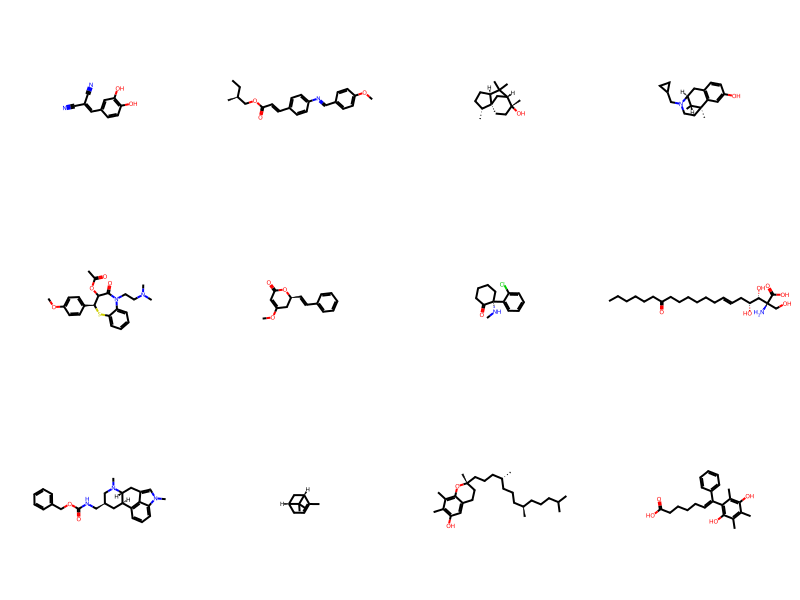

In [16]:
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smi) for smi in standardizirano["smiles_isomeric"][:12]]
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200,200))

In [17]:
#PREIMENOVANJE KOLONA
# Ispis svih kolona
print(standardizirano.columns.tolist())

['PREFERRED_NAME', 'CASRN', 'SMILES', 'smiles_canonic', 'smiles_isomeric', 'Assay List TOX21_AhR_LUC_Agonist-2025-05-31_HIT CALL', 'Assay List TOX21_AP1_BLA_Agonist_ratio-2025-03-17_HIT CALL', 'Assay List TOX21_ARE_BLA_Agonist_ratio-2025-03-17_HIT CALL', 'Assay List TOX21_Aromatase_Inhibition-2025-05-31_HIT CALL', 'Assay List TOX21_AR_BLA_Agonist_ratio-2025-05-31_HIT CALL', 'Assay List TOX21_AR_BLA_Antagonist_ratio-2025-03-17_HIT CALL', 'Assay List TOX21_AR_LUC_MDAKB2_Agonist-2025-05-31_HIT CALL', 'Assay List TOX21_AR_LUC_MDAKB2_Agonist_3uM_Nilutamide-2025-05-31_HIT CALL', 'Assay List TOX21_AR_LUC_MDAKB2_Antagonist_0.5nM_R1881-2025-05-31_HIT CALL', 'Assay List TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881-2025-05-31_HIT CALL', 'Assay List TOX21_CAR_Agonist-2025-05-31_HIT CALL', 'Assay List TOX21_CAR_Antagonist-2025-05-31_HIT CALL', 'Assay List TOX21_CASP3_CHO-2025-05-31_HIT CALL', 'Assay List TOX21_CASP3_HEPG2-2025-05-31_HIT CALL', 'Assay List TOX21_ELG1_LUC_Agonist-2025-05-31_HIT CALL', '

In [18]:
stand_rename_col = standardizirano.rename(columns={
    'Assay List TOX21_AhR_LUC_Agonist-2025-05-31_HIT CALL' : 'TOX21_AhR_LUC_Agonist', 
    'Assay List TOX21_AP1_BLA_Agonist_ratio-2025-03-17_HIT CALL' : 'TOX21_AP1_BLA_Agonist_ratio', 
    'Assay List TOX21_ARE_BLA_Agonist_ratio-2025-03-17_HIT CALL': 'TOX21_ARE_BLA_Agonist_ratio', 
    'Assay List TOX21_Aromatase_Inhibition-2025-05-31_HIT CALL': 'TOX21_Aromatase_Inhibition', 
    'Assay List TOX21_AR_BLA_Agonist_ratio-2025-05-31_HIT CALL':'TOX21_AR_BLA_Agonist_ratio', 
    'Assay List TOX21_AR_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_AR_BLA_Antagonist_ratio', 
    'Assay List TOX21_AR_LUC_MDAKB2_Agonist-2025-05-31_HIT CALL':'TOX21_AR_LUC_MDAKB2_Agonist', 
    'Assay List TOX21_AR_LUC_MDAKB2_Agonist_3uM_Nilutamide-2025-05-31_HIT CALL':'TOX21_AR_LUC_MDAKB2_Agonist_3uM_Nilutamide', 
    'Assay List TOX21_AR_LUC_MDAKB2_Antagonist_0.5nM_R1881-2025-05-31_HIT CALL':'TOX21_AR_LUC_MDAKB2_Antagonist_0.5nM_R1881', 
    'Assay List TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881-2025-05-31_HIT CALL':'TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881', 
    'Assay List TOX21_CAR_Agonist-2025-05-31_HIT CALL':'TOX21_CAR_Agonist', 
    'Assay List TOX21_CAR_Antagonist-2025-05-31_HIT CALL':'TOX21_CAR_Antagonist', 
    'Assay List TOX21_CASP3_CHO-2025-05-31_HIT CALL': 'TOX21_CASP3_CHO', 
    'Assay List TOX21_CASP3_HEPG2-2025-05-31_HIT CALL':'TOX21_CASP3_HEPG2', 
    'Assay List TOX21_ELG1_LUC_Agonist-2025-05-31_HIT CALL':'TOX21_ELG1_LUC_Agonist', 
    'Assay List TOX21_ERa_BLA_Agonist_ratio-2025-05-31_HIT CALL':'TOX21_ERa_BLA_Agonist_ratio', 
    'Assay List TOX21_ERa_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_ERa_BLA_Antagonist_ratio', 
    'Assay List TOX21_ERa_LUC_VM7_Agonist-2025-05-31_HIT CALL': 'TOX21_ERa_LUC_VM7_Agonist', 
    'Assay List TOX21_ERa_LUC_VM7_Agonist_10nM_ICI182780-2025-05-31_HIT CALL':'TOX21_ERa_LUC_VM7_Agonist_10nM_ICI182780', 
    'Assay List TOX21_ERa_LUC_VM7_Antagonist_0.1nM_E2-2025-05-31_HIT CALL':'TOX21_ERa_LUC_VM7_Antagonist_0.1nM_E2', 
    'Assay List TOX21_ERa_LUC_VM7_Antagonist_0.5nM_E2-2025-05-31_HIT CALL':'TOX21_ERa_LUC_VM7_Antagonist_0.5nM_E2', 
    'Assay List TOX21_ERb_BLA_Agonist_ratio-2025-03-17_HIT CALL':'TOX21_ERb_BLA_Agonist_ratio', 
    'Assay List TOX21_ERb_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_ERb_BLA_Antagonist_ratio', 
    'Assay List TOX21_ERR_Agonist-2025-05-31_HIT CALL':'TOX21_ERR_Agonist', 
    'Assay List TOX21_ERR_Antagonist-2025-05-31_HIT CALL':'TOX21_ERR_Antagonist', 
    'Assay List TOX21_ESRE_BLA_ratio-2025-03-17_HIT CALL':'TOX21_ESRE_BLA_ratio', 
    'Assay List TOX21_FXR_BLA_Agonist_ratio-2025-03-17_HIT CALL':'TOX21_FXR_BLA_Agonist_ratio', 
    'Assay List TOX21_FXR_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_FXR_BLA_Antagonist_ratio', 
    'Assay List TOX21_GR_BLA_Agonist_ratio-2025-05-31_HIT CALL':'TOX21_GR_BLA_Agonist_ratio', 
    'Assay List TOX21_GR_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_GR_BLA_Antagonist_ratio', 
    'Assay List TOX21_H2AX_HTRF_CHO_Agonist_ratio-2025-05-31_HIT CALL':'TOX21_H2AX_HTRF_CHO_Agonist_ratio', 
    'Assay List TOX21_HDAC_Inhibition-2025-05-31_HIT CALL':'TOX21_HDAC_Inhibition',
    'Assay List TOX21_HRE_BLA_Agonist_ratio-2025-03-17_HIT CALL':'TOX21_HRE_BLA_Agonist_ratio', 
    'Assay List TOX21_HSE_BLA_Agonist_ratio-2025-03-17.csv_HIT CALL':'TOX21_HSE_BLA_Agonist_ratio', 
    'Assay List TOX21_MMP_fitc-2025-05-31_HIT CALL':'TOX21_MMP_fitc', 
    'Assay List TOX21_MMP_ratio-2025-05-31_HIT CALL':'TOX21_MMP_ratio', 
    'Assay List TOX21_MMP_rhodamine-2025-05-31_HIT CALL':'TOX21_MMP_rhodamine', 
    'Assay List TOX21_NFkB_BLA_agonist_ratio-2025-03-17_HIT CALL':'TOX21_NFkB_BLA_agonist_ratio', 
    'Assay List TOX21_p53_BLA_p1_ratio-2025-03-17_HIT CALL':'TOX21_p53_BLA_p1_ratio', 
    'Assay List TOX21_p53_BLA_p2_ratio-2025-03-17_HIT CALL':'TOX21_p53_BLA_p2_ratio', 
    'Assay List TOX21_p53_BLA_p3_ratio-2025-03-17_HIT CALL':'TOX21_p53_BLA_p3_ratio', 
    'Assay List TOX21_p53_BLA_p4_ratio-2025-03-17_HIT CALL':'TOX21_p53_BLA_p4_ratio', 
    'Assay List TOX21_p53_BLA_p5_ratio-2025-03-17_HIT CALL':'TOX21_p53_BLA_p5_ratio', 
    'Assay List TOX21_PGC_ERR_Agonist-2025-05-31_HIT CALL':'TOX21_PGC_ERR_Agonist', 
    'Assay List TOX21_PGC_ERR_Antagonist-2025-05-31_HIT CALL':'TOX21_PGC_ERR_Antagonist', 
    'Assay List TOX21_PPARd_BLA_Agonist_ratio-2025-03-17_HIT CALL':'TOX21_PPARd_BLA_Agonist_ratio', 
    'Assay List TOX21_PPARd_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_PPARd_BLA_Antagonist_ratio', 
    'Assay List TOX21_PPARg_BLA_Agonist_ratio-2025-05-31_HIT CALL':'TOX21_PPARg_BLA_Agonist_ratio', 
    'Assay List TOX21_PPARg_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_PPARg_BLA_Antagonist_ratio', 
    'Assay List TOX21_PR_BLA_Agonist_ratio-2025-03-17_HIT CALL':'TOX21_PR_BLA_Agonist_ratio', 
    'Assay List TOX21_PR_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_PR_BLA_Antagonist_ratio', 
    'Assay List TOX21_PR_BLA_Followup_Agonist_ratio-2025-05-31_HIT CALL':'TOX21_PR_BLA_Followup_Agonist_ratio', 
    'Assay List TOX21_PR_BLA_Followup_Antagonist_ratio-2025-05-31_HIT CALL':'TOX21_PR_BLA_Followup_Antagonist', 
    'Assay List TOX21_PR_LUC_Followup_Agonist-2025-05-31_HIT CALL':'TOX21_PR_LUC_Followup_Agonist', 
    'Assay List TOX21_PR_LUC_Followup_Antagonist-2025-05-31_HIT CALL':'TOX21_PR_LUC_Followup_Antagonist', 
    'Assay List TOX21_PXR_agonist-2025-05-31_HIT CALL':'TOX21_PXR_agonist', 
    'Assay List TOX21_RAR_LUC_Agonist-2025-05-31_HIT CALL':'TOX21_RAR_LUC_Agonist', 
    'Assay List TOX21_RAR_LUC_Antagonist-2025-05-31_HIT CALL':'TOX21_RAR_LUC_Antagonist', 
    'Assay List TOX21_RORg_LUC_CHO_Antagonist-2025-05-31_HIT CALL':'TOX21_RORg_LUC_CHO_Antagonist', 
    'Assay List TOX21_RXR_BLA_Agonist_ratio-2025-03-17_HIT CALL':'TOX21_RXR_BLA_Agonist_ratio', 
    'Assay List TOX21_SBE_BLA_Agonist_ratio-2025-03-17_HIT CALL':'TOX21_SBE_BLA_Agonist_ratio', 
    'Assay List TOX21_SBE_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_SBE_BLA_Antagonist_ratio', 
    'Assay List TOX21_SHH_3T3_GLI3_Agonist-2025-05-31_HIT CALL':'TOX21_SHH_3T3_GLI3_Agonist', 
    'Assay List TOX21_SHH_3T3_GLI3_Antagonist-2025-05-31_HIT CALL':'TOX21_SHH_3T3_GLI3_Antagonist', 
    'Assay List TOX21_TRA_COA_Agonist_Followup_ratio-2025-05-31_HIT CALL':'TOX21_TRA_COA_Agonist_Followup_ratio', 
    'Assay List TOX21_TRA_COA_Antagonist_Followup_ratio-2025-05-31_HIT CALL':'TOX21_TRA_COA_Antagonist_Followup_ratio', 
    'Assay List TOX21_TRB_BLA_Agonist_Followup_ratio-2025-05-31_HIT CALL':'TOX21_TRB_BLA_Agonist_Followup_ratio', 
    'Assay List TOX21_TRB_BLA_Antagonist_Followup_ratio-2025-05-31_HIT CALL':'TOX21_TRB_BLA_Antagonist_Followup_ratio', 
    'Assay List TOX21_TRB_COA_Agonist_Followup_ratio-2025-05-31_HIT CALL':'TOX21_TRB_COA_Agonist_Followup_ratio', 
    'Assay List TOX21_TRB_COA_Antagonist_Followup_ratio-2025-05-31_HIT CALL':'TOX21_TRB_COA_Antagonist_Followup_ratio', 
    'Assay List TOX21_TRHR_HEK293_agonist-2025-05-31_HIT CALL':'TOX21_TRHR_HEK293_agonist', 
    'Assay List TOX21_TRHR_HEK293_antagonist-2025-05-31_HIT CALL':'TOX21_TRHR_HEK293_antagonist', 
    'Assay List TOX21_TR_LUC_GH3_Agonist-2025-05-31_HIT CALL':'TOX21_TR_LUC_GH3_Agonist', 
    'Assay List TOX21_TR_LUC_GH3_Agonist_Followup-2025-05-31_HIT CALL':'TOX21_TR_LUC_GH3_Agonist_Followup', 
    'Assay List TOX21_TR_LUC_GH3_Antagonist-2025-05-31_HIT CALL':'TOX21_TR_LUC_GH3_Antagonist', 
    'Assay List TOX21_TR_LUC_GH3_Antagonist_Followup-2025-05-31_HIT CALL':'TOX21_TR_LUC_GH3_Antagonist_Followup', 
    'Assay List TOX21_TR_RXR_BLA_Agonist_Followup_ratio-2025-05-31_HIT CALL':'TOX21_TR_RXR_BLA_Agonist_Followup_ratio', 
    'Assay List TOX21_TR_RXR_BLA_Antagonist_Followup_ratio-2025-05-31_HIT CALL':'TOX21_TR_RXR_BLA_Antagonist_Followup_ratio', 
    'Assay List TOX21_TSHR_HTRF_Agonist_ratio-2025-05-31_HIT CALL':'TOX21_TSHR_HTRF_Agonist_ratio', 
    'Assay List TOX21_TSHR_HTRF_Antagonist_ratio-2025-05-31_HIT CALL':'TOX21_TSHR_HTRF_Antagonist_ratio', 
    'Assay List TOX21_TSHR_wt_Agonist_HTRF_ratio-2025-05-31_HIT CALL':'TOX21_TSHR_wt_Agonist_HTRF_ratio', 
    'Assay List TOX21_VDR_BLA_Agonist_ratio-2025-03-17_HIT CALL':'TOX21_VDR_BLA_Agonist_ratio', 
    'Assay List TOX21_VDR_BLA_Antagonist_ratio-2025-03-17_HIT CALL':'TOX21_VDR_BLA_Antagonist_ratio'})

In [19]:
stand_rename_col

,PREFERRED_NAME,CASRN,SMILES,smiles_canonic,smiles_isomeric,TOX21_AhR_LUC_Agonist,TOX21_AP1_BLA_Agonist_ratio,TOX21_ARE_BLA_Agonist_ratio,TOX21_Aromatase_Inhibition,TOX21_AR_BLA_Agonist_ratio,...,TOX21_SBE_BLA_Antagonist_viability_HIT CALL_y,TOX21_SHH_3T3_GLI3_Agonist_viability_HIT CALL_y,TOX21_SHH_3T3_GLI3_Antagonist_viability_HIT CALL_y,TOX21_TRB_BLA_Agonist_Followup_viability_HIT CALL_y,TOX21_TRB_BLA_Antagonist_Followup_viability_HIT CALL_y,TOX21_TR_LUC_GH3_Antagonist_viability_HIT CALL_y,TOX21_TR_RXR_BLA_Agonist_Followup_viability_HIT CALL_y,TOX21_TR_RXR_BLA_Antagonist_Followup_viability_HIT CALL_y,TOX21_VDR_BLA_Agonist_viability_HIT CALL_y,TOX21_VDR_BLA_Antagonist_viability_HIT CALL_y
0,"((3,4-Dihydroxyphenyl)methylene)-Propanedinitrile",118409-57-7,OC1=C(O)C=C(C=C(C#N)C#N)C=C1,N#CC(C#N)=CC1=CC(O)=C(O)C=C1,N#CC(C#N)=CC1=CC(O)=C(O)C=C1,Inactive,Inactive,Active,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
1,(+)-2-Methylbutyl-4-methoxybenzyladine-4'-amin...,24140-30-5,CC[C@H](C)COC(=O)\C=C\C1=CC=C(C=C1)\N=C\C1=CC=...,CCC(C)COC(=O)C=CC1=CC=C(N=CC2=CC=C(OC)C=C2)C=C1,CC[C@H](C)COC(=O)/C=C/C1=CC=C(/N=C/C2=CC=C(OC)...,Inactive,Active,Inactive,Active,Inactive,...,Inactive,Inactive,Active,NaN,NaN,Inactive,NaN,NaN,Active,Active
2,(+)-Cedrol,77-53-2,[H][C@@]12CC[C@@H](C)[C@]11C[C@]([H])(C2(C)C)[...,CC1CCC2C(C)(C)C3CC12CCC3(C)O,C[C@@H]1CC[C@H]2C(C)(C)[C@H]3C[C@@]12CC[C@@]3(C)O,Inactive,Active,Active,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
3,(+)-Cyclazocine,7313-87-3,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,CC1C2CC3=C(C=C(O)C=C3)C1(C)CCN2CC1CC1,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,Inactive,NaN,NaN,NaN,Inactive,...,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,NaN,NaN,NaN
4,(+)-Diltiazem,42399-41-7,COC1=CC=C(C=C1)[C@@H]1SC2=CC=CC=C2N(CCN(C)C)C(...,COC1=CC=C(C2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2OC(C)...,COC1=CC=C([C@@H]2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2...,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6759,trans-beta-Farnesene,18794-84-8,CC(C)=CCC\C(C)=C\CCC(=C)C=C,C=CC(=C)CCC=C(C)CCC=C(C)C,C=CC(=C)CC/C=C(\C)CCC=C(C)C,NaN,Inactive,NaN,NaN,NaN,...,Inactive,Inactive,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6760,{2-[2-(Ethenyloxy)ethoxy]ethoxy}ethene,764-99-8,C=COCCOCCOC=C,C=COCCOCCOC=C,C=COCCOCCOC=C,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6761,{4-[(Ethenyloxy)methyl]cyclohexyl}methanol,114651-37-5,OCC1CCC(COC=C)CC1,C=COCC1CCC(CO)CC1,C=COCC1CCC(CO)CC1,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6762,{4-[({2-[3-Fluoro-4-(trifluoromethyl)phenyl]-4...,317318-84-6,CC1=C(CSC2=CC(C)=C(OCC(O)=O)C=C2)SC(=N1)C1=CC=...,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Active,Active,NaN,NaN,Active,NaN,NaN,Active,Active


In [20]:
stand_rename_col.columns = [
    col.replace("TOX21_", "").replace("_HIT CALL", "") for col in stand_rename_col.columns
]

stand_rename_col

,PREFERRED_NAME,CASRN,SMILES,smiles_canonic,smiles_isomeric,AhR_LUC_Agonist,AP1_BLA_Agonist_ratio,ARE_BLA_Agonist_ratio,Aromatase_Inhibition,AR_BLA_Agonist_ratio,...,SBE_BLA_Antagonist_viability_y,SHH_3T3_GLI3_Agonist_viability_y,SHH_3T3_GLI3_Antagonist_viability_y,TRB_BLA_Agonist_Followup_viability_y,TRB_BLA_Antagonist_Followup_viability_y,TR_LUC_GH3_Antagonist_viability_y,TR_RXR_BLA_Agonist_Followup_viability_y,TR_RXR_BLA_Antagonist_Followup_viability_y,VDR_BLA_Agonist_viability_y,VDR_BLA_Antagonist_viability_y
0,"((3,4-Dihydroxyphenyl)methylene)-Propanedinitrile",118409-57-7,OC1=C(O)C=C(C=C(C#N)C#N)C=C1,N#CC(C#N)=CC1=CC(O)=C(O)C=C1,N#CC(C#N)=CC1=CC(O)=C(O)C=C1,Inactive,Inactive,Active,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
1,(+)-2-Methylbutyl-4-methoxybenzyladine-4'-amin...,24140-30-5,CC[C@H](C)COC(=O)\C=C\C1=CC=C(C=C1)\N=C\C1=CC=...,CCC(C)COC(=O)C=CC1=CC=C(N=CC2=CC=C(OC)C=C2)C=C1,CC[C@H](C)COC(=O)/C=C/C1=CC=C(/N=C/C2=CC=C(OC)...,Inactive,Active,Inactive,Active,Inactive,...,Inactive,Inactive,Active,NaN,NaN,Inactive,NaN,NaN,Active,Active
2,(+)-Cedrol,77-53-2,[H][C@@]12CC[C@@H](C)[C@]11C[C@]([H])(C2(C)C)[...,CC1CCC2C(C)(C)C3CC12CCC3(C)O,C[C@@H]1CC[C@H]2C(C)(C)[C@H]3C[C@@]12CC[C@@]3(C)O,Inactive,Active,Active,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
3,(+)-Cyclazocine,7313-87-3,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,CC1C2CC3=C(C=C(O)C=C3)C1(C)CCN2CC1CC1,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,Inactive,NaN,NaN,NaN,Inactive,...,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,NaN,NaN,NaN
4,(+)-Diltiazem,42399-41-7,COC1=CC=C(C=C1)[C@@H]1SC2=CC=CC=C2N(CCN(C)C)C(...,COC1=CC=C(C2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2OC(C)...,COC1=CC=C([C@@H]2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2...,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6759,trans-beta-Farnesene,18794-84-8,CC(C)=CCC\C(C)=C\CCC(=C)C=C,C=CC(=C)CCC=C(C)CCC=C(C)C,C=CC(=C)CC/C=C(\C)CCC=C(C)C,NaN,Inactive,NaN,NaN,NaN,...,Inactive,Inactive,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6760,{2-[2-(Ethenyloxy)ethoxy]ethoxy}ethene,764-99-8,C=COCCOCCOC=C,C=COCCOCCOC=C,C=COCCOCCOC=C,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6761,{4-[(Ethenyloxy)methyl]cyclohexyl}methanol,114651-37-5,OCC1CCC(COC=C)CC1,C=COCC1CCC(CO)CC1,C=COCC1CCC(CO)CC1,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6762,{4-[({2-[3-Fluoro-4-(trifluoromethyl)phenyl]-4...,317318-84-6,CC1=C(CSC2=CC(C)=C(OCC(O)=O)C=C2)SC(=N1)C1=CC=...,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Active,Active,NaN,NaN,Active,NaN,NaN,Active,Active


In [21]:
# Prvih 5 kolona ostaju nepromijenjene
fixed_cols = list(stand_rename_col.columns[:5])

# Ostalim kolonama dodajemo sufiks "_HitCall" (za lakše raspoznavanje targeta od deskriptra i fp-a)
renamed_cols = [col + "_HitCall" for col in stand_rename_col.columns[5:]]

# Spajanje imena u novu listu
new_columns = fixed_cols + renamed_cols

# Dodjela novih imena tablici
stand_rename_col.columns = new_columns
stand_rename_col

,PREFERRED_NAME,CASRN,SMILES,smiles_canonic,smiles_isomeric,AhR_LUC_Agonist_HitCall,AP1_BLA_Agonist_ratio_HitCall,ARE_BLA_Agonist_ratio_HitCall,Aromatase_Inhibition_HitCall,AR_BLA_Agonist_ratio_HitCall,...,SBE_BLA_Antagonist_viability_y_HitCall,SHH_3T3_GLI3_Agonist_viability_y_HitCall,SHH_3T3_GLI3_Antagonist_viability_y_HitCall,TRB_BLA_Agonist_Followup_viability_y_HitCall,TRB_BLA_Antagonist_Followup_viability_y_HitCall,TR_LUC_GH3_Antagonist_viability_y_HitCall,TR_RXR_BLA_Agonist_Followup_viability_y_HitCall,TR_RXR_BLA_Antagonist_Followup_viability_y_HitCall,VDR_BLA_Agonist_viability_y_HitCall,VDR_BLA_Antagonist_viability_y_HitCall
0,"((3,4-Dihydroxyphenyl)methylene)-Propanedinitrile",118409-57-7,OC1=C(O)C=C(C=C(C#N)C#N)C=C1,N#CC(C#N)=CC1=CC(O)=C(O)C=C1,N#CC(C#N)=CC1=CC(O)=C(O)C=C1,Inactive,Inactive,Active,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
1,(+)-2-Methylbutyl-4-methoxybenzyladine-4'-amin...,24140-30-5,CC[C@H](C)COC(=O)\C=C\C1=CC=C(C=C1)\N=C\C1=CC=...,CCC(C)COC(=O)C=CC1=CC=C(N=CC2=CC=C(OC)C=C2)C=C1,CC[C@H](C)COC(=O)/C=C/C1=CC=C(/N=C/C2=CC=C(OC)...,Inactive,Active,Inactive,Active,Inactive,...,Inactive,Inactive,Active,NaN,NaN,Inactive,NaN,NaN,Active,Active
2,(+)-Cedrol,77-53-2,[H][C@@]12CC[C@@H](C)[C@]11C[C@]([H])(C2(C)C)[...,CC1CCC2C(C)(C)C3CC12CCC3(C)O,C[C@@H]1CC[C@H]2C(C)(C)[C@H]3C[C@@]12CC[C@@]3(C)O,Inactive,Active,Active,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
3,(+)-Cyclazocine,7313-87-3,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,CC1C2CC3=C(C=C(O)C=C3)C1(C)CCN2CC1CC1,C[C@@H]1[C@@H]2CC3=C(C=C(O)C=C3)[C@@]1(C)CCN2C...,Inactive,NaN,NaN,NaN,Inactive,...,NaN,NaN,NaN,NaN,NaN,Inactive,NaN,NaN,NaN,NaN
4,(+)-Diltiazem,42399-41-7,COC1=CC=C(C=C1)[C@@H]1SC2=CC=CC=C2N(CCN(C)C)C(...,COC1=CC=C(C2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2OC(C)...,COC1=CC=C([C@@H]2SC3=CC=CC=C3N(CCN(C)C)C(=O)C2...,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Active,NaN,NaN,Inactive,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6759,trans-beta-Farnesene,18794-84-8,CC(C)=CCC\C(C)=C\CCC(=C)C=C,C=CC(=C)CCC=C(C)CCC=C(C)C,C=CC(=C)CC/C=C(\C)CCC=C(C)C,NaN,Inactive,NaN,NaN,NaN,...,Inactive,Inactive,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6760,{2-[2-(Ethenyloxy)ethoxy]ethoxy}ethene,764-99-8,C=COCCOCCOC=C,C=COCCOCCOC=C,C=COCCOCCOC=C,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6761,{4-[(Ethenyloxy)methyl]cyclohexyl}methanol,114651-37-5,OCC1CCC(COC=C)CC1,C=COCC1CCC(CO)CC1,C=COCC1CCC(CO)CC1,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Inactive,Inactive,NaN,NaN,Inactive,NaN,NaN,Inactive,Inactive
6762,{4-[({2-[3-Fluoro-4-(trifluoromethyl)phenyl]-4...,317318-84-6,CC1=C(CSC2=CC(C)=C(OCC(O)=O)C=C2)SC(=N1)C1=CC=...,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...,CC1=C(OCC(=O)O)C=CC(SCC2=C(C)N=C(C3=CC=C(C(F)(...,Inactive,Inactive,Inactive,NaN,Inactive,...,Inactive,Active,Active,NaN,NaN,Active,NaN,NaN,Active,Active


In [22]:
stand_rename_col.to_csv("stand_rename_col.csv", index=False)